# Введение #
Я аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Мне предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
## Описание тарифов
### Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей
### Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей
Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.
# Обработка данных #
## Знакомство с данными
Первым делом загрузим необходимые библиотеки и откроем файлы

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from scipy import stats as st
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Проверим данные на пропуски и несоответствия форматов.

In [2]:
display(calls)
calls.info(memory_usage='deep')
calls.duplicated().sum()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6 MB


0

В этой таблице хранятся данные о дате и длительности каждого звонка для каждого пользователя. Единственное, что вызывает вопрос - столбец id. Хранить номер пользователя(что тянет формат object для этого столбца) при наличии чтолбца user_id излишне. Даты надо привести к формату дат. Длительность звонка в минутах надо округлить вверх, так как это указано в информации о тарификации оператора "Мегалайн". Звонки с нулевым значением стоит считать несостоявшимися и они не показательны для нашего исследования - мы их отбросим.

In [3]:
display(internet)
internet.info()
internet.duplicated().sum()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


0

Столбец с индексами продублировался - его надо будет убрать. Необходимо округлить вверх столбец с мегабайтами. Сессии с размером трафика 0 мБ стоит признать несостоявшимися и отбросить.

In [4]:
display(messages)
messages.info()
messages.duplicated().sum()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


0

Столбец с id сообщений исправить и формат даты и времени. Переименуем столбец tariff_name для последующего присоединения.

In [5]:
display(tariffs)
tariffs.info()
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [6]:
display(users)
users.info()
users.duplicated().sum()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


0

Тут тоже все хорошо, пропуски в churn_date означают, что пользователь до сих пор пользуется тарифом. Необходимо привести к формату даты и времени столбцы reg_date и churn_date. Узнаем все ли пользователи пользуются тарифами "Смарт" и "Ультра", в ином случае информация по этим пользователям будет бесполезна.

In [7]:
print(users['tariff'].value_counts())
print(users['churn_date'].isna().sum())

smart    351
ultra    149
Name: tariff, dtype: int64
462


462 из 500 пользователей продолжают пользоваться тарифами.
## Обработка
### Обработка пропусков, округление, изменение типов данных
В соответствии с тарифами надо округлить вверх длительность звонков и траффик интернет-сессий.


In [8]:
calls['duration'] = np.ceil(calls['duration'])
calls = calls[calls['duration'] !=0]
internet['mb_used'] = np.ceil(internet['mb_used'])
internet = internet[internet['mb_used'] !=0]


Напишем программу, которая изменяет id звонка, сообщения или интернет-сессии на порядковый номер

In [9]:
def idedit(df, column):
    lines2=[]
    for lines in df[column]:
        lines=lines.split('_')
        lines2.append(int(lines[1]))
    df[column]=lines2
    return 
idedit(calls, 'id')
calls.info(memory_usage='deep')
idedit(messages, 'id')
idedit(internet, 'id')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
id           162994 non-null int64
call_date    162994 non-null object
duration     162994 non-null float64
user_id      162994 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 15.4 MB


Например в датафрейме calls почти в 2 раза сократилась используемая память, при сохранении всей и информации. Приступим к обработке даты и времени, напишем програму, которая переводит в нескольких столбцах датафрейма строки к формату даты.

In [10]:
def to_date(df,columns):
    for column in columns:
        df[column]=pd.to_datetime(df[column], format='%Y-%m-%d')
    return
to_date(users, ['reg_date', 'churn_date'])
to_date(messages,['message_date'])
to_date(internet, ['session_date'])
to_date(calls, ['call_date'])

# Расчет и анализ данных

## Расчет данных по месяцам
Рассчитаем данные по потраченным сообщениям, минутам, интернет-траффику по месяцам для каждого пользователя.

In [11]:
calls['month']=pd.DatetimeIndex(calls['call_date']).month
calls_month=calls.pivot_table(index=['user_id','month'],values='duration',aggfunc=['count','sum'])
calls_month.columns=['calls','minutes']
messages['month']=pd.DatetimeIndex(messages['message_date']).month
messages_month=messages.pivot_table(index=['user_id','month'],values='message_date',aggfunc='count')
messages_month.columns=['messages']
internet['month']=pd.DatetimeIndex(internet['session_date']).month
internet_month=internet.pivot_table(index=['user_id','month'],values='mb_used',aggfunc=['count','sum'])
internet_month.columns=['sessions','traffic']
internet_month


sessions  traffic
user_id month                   
1000    5             4   2256.0
        6            44  23257.0
        7            28  14016.0
        8            27  14070.0
        9            25  14581.0
...                 ...      ...
1498    10           49  20604.0
1499    9             4   1848.0
        10           43  17809.0
        11           39  17984.0
        12           40  13077.0

[3201 rows x 2 columns]

Для каждого вида использования мобильной сети у нас есть таблица в которой для каждого пользователя посчитана его месячная активность, совместим это все в одну таблицу.

In [12]:
monthly_activity=calls_month
monthly_activity=monthly_activity.merge(messages_month, on=['user_id','month'], how='outer')
monthly_activity=monthly_activity.merge(internet_month, on=['user_id','month'], how='outer')
monthly_activity.reset_index(inplace=True) 
display(monthly_activity)
monthly_activity.info()


,user_id,month,calls,minutes,messages,sessions,traffic
0,1000,5,17.0,159.0,22.0,4.0,2256.0
1,1000,6,28.0,172.0,60.0,44.0,23257.0
2,1000,7,41.0,340.0,75.0,28.0,14016.0
3,1000,8,42.0,408.0,81.0,27.0,14070.0
4,1000,9,46.0,466.0,57.0,25.0,14581.0
...,...,...,...,...,...,...,...
3209,1489,10,NaN,NaN,21.0,52.0,19588.0
3210,1489,11,NaN,NaN,20.0,45.0,17516.0
3211,1489,12,NaN,NaN,35.0,43.0,17341.0
3212,1240,2,NaN,NaN,NaN,3.0,961.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 7 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3168 non-null float64
minutes     3168 non-null float64
messages    2717 non-null float64
sessions    3201 non-null float64
traffic     3201 non-null float64
dtypes: float64(5), int64(2)
memory usage: 175.9 KB


Присутствуют пропущенные значения. Скорее всего пользователи не пользовались услугами мобильной сети в данный период. Это можно заполнить нулями.

In [13]:
monthly_activity['calls']=monthly_activity['calls'].fillna(0)
monthly_activity['minutes']=monthly_activity['minutes'].fillna(0)
monthly_activity['messages']=monthly_activity['messages'].fillna(0) 
monthly_activity['sessions']=monthly_activity['sessions'].fillna(0)
monthly_activity['traffic']=monthly_activity['traffic'].fillna(0)

Теперь добавим информацию об используемом тарифе для каждого пользователя вместе с тарифными условиями.

In [14]:
monthly_activity= monthly_activity.merge(users, on='user_id', how='left').merge(tariffs, on='tariff',how='left')
display(monthly_activity)

,user_id,month,calls,minutes,messages,sessions,traffic,age,churn_date,city,...,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,17.0,159.0,22.0,4.0,2256.0,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,28.0,172.0,60.0,44.0,23257.0,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,41.0,340.0,75.0,28.0,14016.0,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,42.0,408.0,81.0,27.0,14070.0,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,46.0,466.0,57.0,25.0,14581.0,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,10,0.0,0.0,21.0,52.0,19588.0,35,NaT,Санкт-Петербург,...,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3210,1489,11,0.0,0.0,20.0,45.0,17516.0,35,NaT,Санкт-Петербург,...,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3211,1489,12,0.0,0.0,35.0,43.0,17341.0,35,NaT,Санкт-Петербург,...,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3212,1240,2,0.0,0.0,0.0,3.0,961.0,30,NaT,Воронеж,...,Шарова,2018-02-27,ultra,1000,30720,3000,1950,150,1,1


Не все данные нам понадобятся для дальнейшего анализа

In [15]:
monthly_activity = monthly_activity.drop(['first_name', 'last_name', 'age', 'churn_date'], axis = 'columns')

Добавим столбцы с использованием услуг сверх тарифного плана.

In [16]:
monthly_activity['minutes_over'] = monthly_activity['minutes'] - monthly_activity['minutes_included']
monthly_activity['messages_over'] = monthly_activity['messages'] - monthly_activity['messages_included']
monthly_activity['traffic_over'] = monthly_activity['traffic'] - monthly_activity['mb_per_month_included']

Если эти значения положительные - то идет перерасход по цене в тарифном плане - на нее надо умножить. Уберем отрицательные значения перерасхода, а затем помножим величину перерасхода на стоимость услуг.

In [17]:
monthly_activity.loc[monthly_activity['minutes_over']<=0, 'minutes_over'] = 0 
monthly_activity.loc[monthly_activity['messages_over']<=0, 'messages_over'] = 0 
monthly_activity.loc[monthly_activity['traffic_over']<=0, 'traffic_over'] = 0 
monthly_activity['rub_over_minutes']=monthly_activity['minutes_over']*monthly_activity['rub_per_minute']
monthly_activity['rub_over_messages']=monthly_activity['messages_over']*monthly_activity['rub_per_message']
monthly_activity['rub_over_traffic']=monthly_activity['traffic_over']*monthly_activity['rub_per_gb']/1024 


Мы получили перерасход в рублях по каждому виду услуг мобильной сети, теперь сложим их и получим весь перерасход для пользователя, а эту величину сложим со стоимостью тарифного плана и получим все затраты клиента  за месяц.

In [18]:
monthly_activity['rub_over'] = monthly_activity['rub_over_minutes']+monthly_activity['rub_over_messages']+monthly_activity['rub_over_traffic']
monthly_activity['rub_total'] = monthly_activity['rub_over']+monthly_activity['rub_monthly_fee']
monthly_activity = monthly_activity.drop(['rub_per_message', 'rub_per_minute', 'rub_per_gb','reg_date','minutes_included'],
                                         axis = 'columns')
display(monthly_activity)

,user_id,month,calls,minutes,messages,sessions,traffic,city,tariff,messages_included,mb_per_month_included,rub_monthly_fee,minutes_over,messages_over,traffic_over,rub_over_minutes,rub_over_messages,rub_over_traffic,rub_over,rub_total
0,1000,5,17.0,159.0,22.0,4.0,2256.0,Краснодар,ultra,1000,30720,1950,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1950.000000
1,1000,6,28.0,172.0,60.0,44.0,23257.0,Краснодар,ultra,1000,30720,1950,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1950.000000
2,1000,7,41.0,340.0,75.0,28.0,14016.0,Краснодар,ultra,1000,30720,1950,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1950.000000
3,1000,8,42.0,408.0,81.0,27.0,14070.0,Краснодар,ultra,1000,30720,1950,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1950.000000
4,1000,9,46.0,466.0,57.0,25.0,14581.0,Краснодар,ultra,1000,30720,1950,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,10,0.0,0.0,21.0,52.0,19588.0,Санкт-Петербург,smart,50,15360,550,0.0,0.0,4228.0,0.0,0.0,825.781250,825.781250,1375.781250
3210,1489,11,0.0,0.0,20.0,45.0,17516.0,Санкт-Петербург,smart,50,15360,550,0.0,0.0,2156.0,0.0,0.0,421.093750,421.093750,971.093750
3211,1489,12,0.0,0.0,35.0,43.0,17341.0,Санкт-Петербург,smart,50,15360,550,0.0,0.0,1981.0,0.0,0.0,386.914062,386.914062,936.914062
3212,1240,2,0.0,0.0,0.0,3.0,961.0,Воронеж,ultra,1000,30720,1950,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1950.000000


## Анализ

Создадим сводную таблицу по тарифам относительно месяцев.

In [19]:
monthly_tariffs = monthly_activity.pivot_table(index=['tariff', 'month'], 
                                                values = ['minutes','messages','traffic','rub_over','rub_total'])
tarrif_activity= monthly_tariffs.pivot_table(index='tariff', 
                                            values = ['minutes','messages','traffic','rub_over','rub_total'])
display(tarrif_activity)

,messages,minutes,rub_over,rub_total,traffic
tariff,,,,,
smart,31.413211,386.760499,580.319400,1130.319400,15077.690651
ultra,43.714983,495.934310,88.917311,2038.917311,18222.784561


Вывод:
- Пользователи тарифа Ультра приносят денег в почти в 2 раза больше, при этом они мало используют услуги сверх тарифного плана и нагрузка на сеть не так различается с тарифом Смарт, как выручка.
- Пользователи тарифа Смарт приносят в целом меньше денег, но очень большая часть денег идет из-за перерасхода.

**Посмотрим как пользователи Москвы и других городов используют мобильную сеть.**

In [20]:
monthly_activity.loc[monthly_activity['city']!= 'Москва', 'city'] = 'другой'
city_activity = monthly_activity.pivot_table(index='city',
                                            values = ['minutes','messages','traffic','rub_over','rub_total'])
display(city_activity)

,messages,minutes,rub_over,rub_total,traffic
city,,,,,
Москва,37.877250,469.150573,441.728480,1507.276762,17984.068740
другой,38.376104,447.041875,523.304603,1482.063727,17050.016519


В Москве больше разговаривают по телефону и больше используют мобильную сеть, но различия очень малы.
## Расчет статистических показателей

Разделим данные в соответствии с тарифом

In [21]:
smart = monthly_activity[monthly_activity['tariff']=='smart']
ultra = monthly_activity[monthly_activity['tariff']=='ultra']

Далее мы можем рассчитывать статистические показатели для каждого тарифа и сравнить их между собой. Начнем с звонков.

In [22]:
print(smart['minutes'].describe())
print(ultra['minutes'].describe())

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: minutes, dtype: float64
count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: minutes, dtype: float64


- Тарифом Смарт пользовались 2229 раз, а Ультра 985, что пропорционально количеству пользователей.
- В тарифе Смарт стандартное отклонение 190, в Ультра 317
По распределению по квартилям, различии в стандартном отклонении и средним, можно предположить, что пользователи на тарифе Ультра любят говорить дольше.

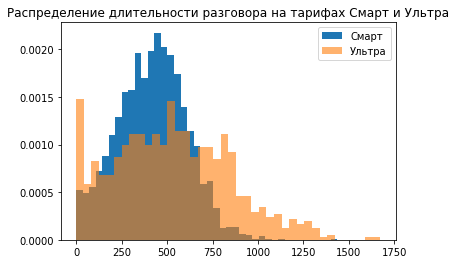

Дисперсия в тарифе Смарт 36203.07
Дисперсия в тарифе Ультра 100771.22


In [23]:
plt.title('Распределение длительности разговора на тарифах Смарт и Ультра')
plt.hist(smart['minutes'], bins=40, label='Смарт', density= True)
plt.hist(ultra['minutes'], bins=40, label= 'Ультра', density= True, alpha= 0.6)
plt.legend()
plt.show()
print('Дисперсия в тарифе Смарт {:.2f}'.format(np.var(smart['minutes'])))
print('Дисперсия в тарифе Ультра {:.2f}'.format(np.var(ultra['minutes'])))

Стоит помнить, что тарифом Ультра пользуется меньше клиентов, поэтому график в целом ниже. 
- Максимум распределения смещен немного правее тарифа Смарт. Правый хвост довольно длинный и высокий, так как пользователи могут это позволить себе. 
- Наибольшее количество пользователей тарифа Смарт используют все доступное время, довольно много используют свыше доступного.
Далее посмотрим на сообщения

In [24]:
print(smart['messages'].describe())
print(ultra['messages'].describe())

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64
count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64


На первый взгляд расспределение сообщений будет похоже на распределение длительности звонков, за тем исключением, что около нуля будет довольно высокая доля в распределении.

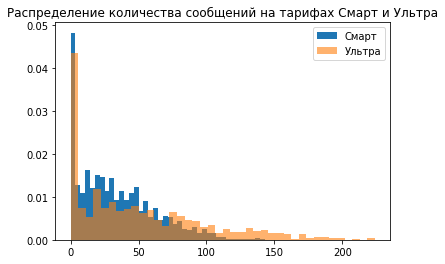

Дисперсия в тарифе Смарт 796.46
Дисперсия в тарифе Ультра 2282.95


In [25]:
plt.title('Распределение количества сообщений на тарифах Смарт и Ультра')
plt.hist(smart['messages'], bins=40, label='Смарт', density= True)
plt.hist(ultra['messages'], bins=40, label= 'Ультра', density= True, alpha= 0.6)
plt.legend()
plt.show()
print('Дисперсия в тарифе Смарт {:.2f}'.format(np.var(smart['messages'])))
print('Дисперсия в тарифе Ультра {:.2f}'.format(np.var(ultra['messages'])))

- Достаточно высокая доля в тарифе Смарт свыше лимита в 50 сообщений и распределение не так резко заканчивается, как это было со звонками.
- Пользователи тарифа Ультра в меньшей степени отказывают себе в отправке сообщений, но до лимита в 1000 сообщений в тарифе им гораздо дальше.
Интернет траффик

In [26]:
print(smart['traffic'].describe())
print(ultra['traffic'].describe())

count     2229.000000
mean     16229.188425
std       5877.576978
min          0.000000
25%      12658.000000
50%      16531.000000
75%      20068.000000
max      38610.000000
Name: traffic, dtype: float64
count      985.000000
mean     19486.901523
std      10096.317202
min          0.000000
25%      11785.000000
50%      19324.000000
75%      26863.000000
max      49789.000000
Name: traffic, dtype: float64


Для обоих тарифов количествопользователей незначительно меньше, чем раньше - не все используют мобильный интернет, хотя он и включен в стоимость тарифа.

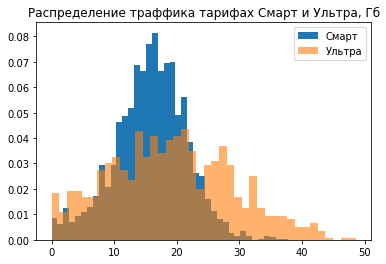

Дисперсия в тарифе Смарт 32.93
Дисперсия в тарифе Ультра 97.11


In [27]:
plt.title('Распределение траффика тарифах Смарт и Ультра, Гб')
plt.hist(smart['traffic']/1024, bins=40, label='Смарт', density= True)
plt.hist(ultra['traffic']/1024, bins=40, label= 'Ультра', density= True, alpha= 0.6)
plt.legend()
plt.show()
print('Дисперсия в тарифе Смарт {:.2f}'.format(np.var(smart['traffic']/1024)))
print('Дисперсия в тарифе Ультра {:.2f}'.format(np.var(ultra['traffic']/1024)))

Для удобства восприятия величины были переведены в гигабайты. 
- Для тарифа Смарт ситуация похожа на звонки: большинство упирается в лимит трафика, но очень много людей его перерасходуют
- Распределение для тарифа Ультра тоже выходит за рамки выделенного лимита. Виден пик перед 30 гБ - пользователи, которые решили не перебирать трафика, израсходовав месячный план.
В общем у меня сложилось впечатление, что тариф Смарт может приносить больше денег, чем тариф Ультра, потому что в  тарифе Смарт перерасход услуг стоит дороже. Доля(и количество) клиентов тарифа Смарт, которые выходят за лимит тарифа, выше, чем в тарифе Ультра.



## Проверка статистических гипотез
**Гипотеза 1**  
Нулевая гипотеза: выручка за перерасход обоих тарифов равна.  
Альтернативная гипотеза:выручка за перерасход обоих тарифов не равна.

In [28]:
alpha = 0.05
print('Средняя выручка за перерасход тарифа Смарт {:.2f}'.format(smart['rub_over'].mean()))
print('Средняя выручка за перерасход тарифа Ультра {:.2f}'.format(ultra['rub_over'].mean()))
print('Дисперсия величины для тарифа Смарт {:.0f}'.format(np.var(smart['rub_over'],ddof=1)))
print('Дисперсия величины для  тарифа Ультра {:.0f}'.format(np.var(ultra['rub_over'],ddof=1)))
results = st.ttest_ind(smart['rub_over'],
    ultra['rub_over'],equal_var= False)

print('p-значение:', results.pvalue)

if (results.pvalue<alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка за перерасход тарифа Смарт 683.35
Средняя выручка за перерасход тарифа Ультра 110.53
Дисперсия величины для тарифа Смарт 620453
Дисперсия величины для  тарифа Ультра 126953
p-значение: 2.4833041148378475e-158
Отвергаем нулевую гипотезу


**Гипотеза 2**  
Нулевая гипотеза: средняя общая выручка обоих тарифов равна.  
Альтернативная гипотеза: средняя общая выручка обоих тарифов различается.  

In [29]:
alpha = 0.05
print('Средняя общая выручка тарифа Смарт {:.2f}'.format(smart['rub_total'].mean()))
print('Средняя общая выручка тарифа Ультра {:.2f}'.format(ultra['rub_total'].mean()))
print('Дисперсия величины для тарифа Смарт {:.0f}'.format(np.var(smart['rub_total'],ddof=1)))
print('Дисперсия величины для  тарифа Ультра {:.0f}'.format(np.var(ultra['rub_total'],ddof=1)))

results = st.ttest_ind(smart['rub_total'],
    ultra['rub_total'],equal_var= False)

print('p-значение:', results.pvalue)

if (results.pvalue<alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя общая выручка тарифа Смарт 1233.35
Средняя общая выручка тарифа Ультра 2060.53
Дисперсия величины для тарифа Смарт 620453
Дисперсия величины для  тарифа Ультра 126953
p-значение: 8.931402711368788e-296
Отвергаем нулевую гипотезу


**Гипотеза 3**  
Нулевая гипотеза: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. 
Альтернативная гипотеза: средняя выручка пользователей из Москвы и пользователей из других регионов отличаются.  

In [30]:
alpha = 0.05
moscow_activity=monthly_activity.query('city == "Москва"')
other_activity=monthly_activity.query('city == "другой"')
print('Средняя общая выручка в Москве {:.2f}'.format(moscow_activity['rub_total'].mean()))
print('Средняя общая выручка в другихгородах {:.2f}'.format(other_activity['rub_total'].mean()))
print('Дисперсия величины для Москвы {:.0f}'.format(np.var(moscow_activity['rub_total'], ddof=1)))
print('Дисперсия величины для других городов {:.0f}'.format(np.var(other_activity['rub_total'],ddof=1)))

results = st.ttest_ind(moscow_activity['rub_total'],
    other_activity['rub_total'],equal_var= False)

print('p-значение:', results.pvalue)

if (results.pvalue<alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя общая выручка в Москве 1507.28
Средняя общая выручка в другихгородах 1482.06
Дисперсия величины для Москвы 547243
Дисперсия величины для других городов 630504
p-значение: 0.4549775646471024
Не получилось отвергнуть нулевую гипотезу


# Общий вывод
- Пользователи тарифа Ультра приносят денег в почти в 2 раза больше, при этом они мало используют услуги сверх тарифного плана и нагрузка на сеть не так различается с тарифом Смарт, как выручка.
- Пользователи тарифа Смарт приносят в целом меньше денег, но очень большая часть(более 50%) денег идет из-за перерасхода.
- Пользователи тарифа Смарт чаще платят за перерасход, когда пользователи тарифа Ультра практически не пересходуют(4% от общей выручки) услуги, за исключением мобильного интеренета.
- Клиенты тарифа Смарт платят в 6 раз больше больше за перерасход услуг
- Для мобильного оператора более выгоден тариф Ультра, который позволяет клиентам использовать мобильную сеть не выходя за рамки лимитов, а общая выручка будет выше почти в 2 раза
- Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.  
  
**Рекомендации**  
- Стоит пересмотреть рекламную политику в Московском регионе, так как клиентская база платежеспособная, а выручка не различается.
- Общий упор стоит делать на тариф Смарт, так как средняя общая выручка больше